In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

In [5]:
df = pd.read_csv(
        '~/Documents/Deep Learning Masterclass/DATA/RSCCASN.csv', 
        parse_dates=True,
        index_col = 'DATE',
    )

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB
None


,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

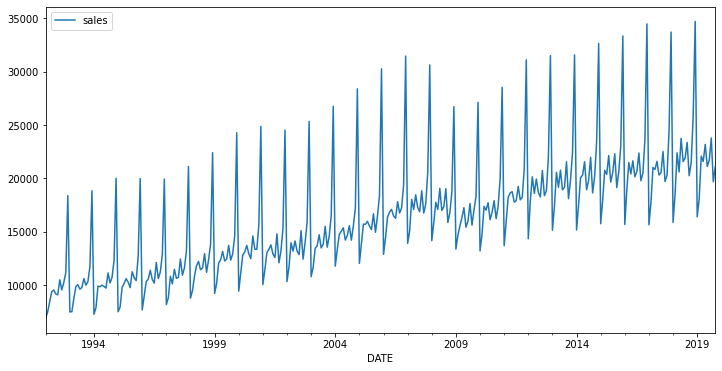

In [8]:
df.columns = ['sales']

df.plot(figsize=(12, 6))

In [9]:
len(df)

334

In [10]:
# Choosing 1.5 years for test data

test_size = 18

cutoff_index = int(len(df) - test_size)
cutoff_index

316

# Test Train Split

In [11]:
train = df.iloc[ : cutoff_index]

test = df.iloc [cutoff_index : ]

In [14]:
train.tail()

,sales
DATE,
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616


In [13]:
test.head()

,sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


# Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [16]:
scaled_train = scaler.fit_transform(train)

scaled_test = scaler.transform(test)

# Defining Batches

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12 # This should be lesser than len(test_df)
batch_size = 1

generator = TimeseriesGenerator(
                scaled_train, 
                scaled_train,
                length=length,
                batch_size=batch_size,
            )

In [26]:
X, y = generator[0]

print(f'Given X:\n {X}')
print(f'\nPredicted y: {y}')

print('Verifying by looking into original scaled train data...')
scaled_train[0 : 13]

Given X:
 [[[0.        ]
  [0.02127505]
  [0.05580163]
  [0.08942056]
  [0.09512053]
  [0.08146965]
  [0.07860151]
  [0.12979233]
  [0.09566512]
  [0.1203892 ]
  [0.15426227]
  [0.41595266]]]

Predicted y: [[0.02047633]]
Verifying by looking into original scaled train data...


array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633]])

# Building Models

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

n_features = 1

model = Sequential()

model.add(LSTM(100, input_shape=(length, n_features), activation='relu'))

model.add(Dense(1))

model.compile('adam', 'mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
validation_generator = TimeseriesGenerator(
                            scaled_test, 
                            scaled_test, 
                            length=length,
                            batch_size=batch_size,
                        )

In [31]:
model.fit_generator(
    generator, 
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[early_stop]
)

/usr/local/anaconda3/envs/neural-engine/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 4s 6ms/step - loss: 0.0255 - val_loss: 0.0117
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0173 - val_loss: 0.0022
Epoch 3/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0119 - val_loss: 0.0019
Epoch 4/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 5.4348e-04
Epoch 5/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 7.9665e-04
Epoch 6/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 0.0012


# Checking Model Performance

<AxesSubplot:>

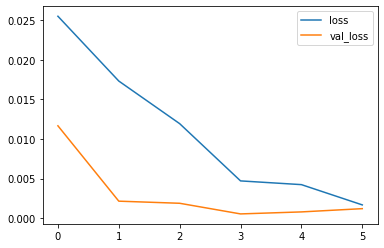

In [32]:
metrics = pd.DataFrame(model.history.history)

metrics.plot()

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-length : ]
current_batch = first_eval_batch.reshape(1, length, n_features) 

for i in range(len(scaled_test)):
    
    
              
    current_prediction = model.predict(current_batch)[0]
    
    test_predictions.append(current_prediction)
              
    current_batch = np.append(
                        current_batch[: , 1: , :],
                        [[current_prediction]], 
                        axis=1
                    )

In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

test['predictions'] = true_predictions

test.head()

/usr/local/anaconda3/envs/neural-engine/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sales,predictions
DATE,,
2018-05-01,23764,21967.367330
2018-06-01,21589,20876.593332
2018-07-01,21919,21148.373608
2018-08-01,23381,23001.285872
2018-09-01,20260,20507.682181


<AxesSubplot:xlabel='DATE'>

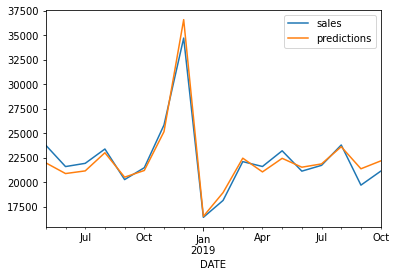

In [37]:
test.plot()

# Finalizing the Model

In [39]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

In [40]:
generator = TimeseriesGenerator(
                scaled_full_data, 
                scaled_full_data,
                length=length,
                batch_size=batch_size,
            )

In [41]:
model = Sequential()

model.add(LSTM(100, input_shape=(length, n_features), activation='relu'))

model.add(Dense(1))

model.compile('adam', 'mse')

In [42]:
model.fit_generator(
    generator, 
    epochs=5, # In loss plot, the lowest val is at epoch #5
)

/usr/local/anaconda3/envs/neural-engine/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
322/322 [==============================] - 3s 6ms/step - loss: 0.0265
Epoch 2/5
322/322 [==============================] - 1s 5ms/step - loss: 0.0158
Epoch 3/5
322/322 [==============================] - 2s 6ms/step - loss: 0.0115
Epoch 4/5
322/322 [==============================] - 2s 6ms/step - loss: 0.0055
Epoch 5/5
322/322 [==============================] - 2s 6ms/step - loss: 0.0019


# Making Predictions

* Keep periods = length

In [43]:
forecast = []

periods = 12 # Predict the sales for next 1 year

first_eval_batch = scaled_train[-length : ]
current_batch = first_eval_batch.reshape(1, length, n_features)

for i in range(periods):
    
    
              
    current_prediction = model.predict(current_batch)[0]
    forecast.append(current_prediction)
              
    current_batch = np.append(
                        current_batch[: , 1: , :],
                        [[current_prediction]], 
                        axis=1
                    )

In [44]:
forecast = scaler.inverse_transform(forecast)

In [45]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq='MS')
# freq -> Should it repeat daily, monthly, or yearly?

In [47]:
forecast_df = pd.DataFrame(forecast, forecast_index, ['forecast'])

forecast_df.head()

,forecast
2019-11-01,21190.683156
2019-12-01,20065.491504
2020-01-01,20248.717408
2020-02-01,21997.442554
2020-03-01,19645.998025


(576.0, 611.0)

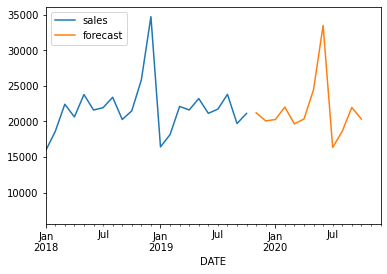

In [49]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01')